In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from methods import models
from methods import protocols
from methods import data2 as data
from methods import utils
from methods import results, run, t_hold, v_hold

In [2]:
m = '../models/iyer-2007-ina.mmt'
model = models.VCModel(m, False, False, models.VC_FULL)
ideal = models.VCModel(m, False, False, models.VC_IDEAL)

/Users/chonloklei/work/dev/hERG-mutant-2023/venv/lib/python3.9/site-packages/myokit/_model_api.py:4897: UserWarning: The method `set_state_value` is deprecated. Please use `set_initial_value` instead.
  warnings.warn(


In [3]:
dname = 'cell5'
dt = 0.04  # ms
discard_start = 0
remove = 0 + discard_start
'''
step_duration = 39 - remove  # ms
discard = remove + 2000  # ms
v_steps = data._naiv(dname)
protocol = protocols.load('../protocols/ina-steps-3.txt')
'''
step_duration = 40 - remove  # ms
discard = remove + 0  # ms
v_steps = data._naiv(dname)
protocol = protocols.load('../protocols/ina-steps-2-no-holding.txt')
t_hold = 0 # ms
#'''

model.set_protocol(protocol, dt=dt, v_hold=v_hold, t_hold=t_hold)
mask = protocols.mask(model.times(), step_duration, discard=discard)
model.set_protocol(protocol, dt=dt, v_hold=v_hold, t_hold=t_hold, mask=mask)
ideal.set_protocol(protocol, dt=dt, v_hold=v_hold, t_hold=t_hold, mask=mask)


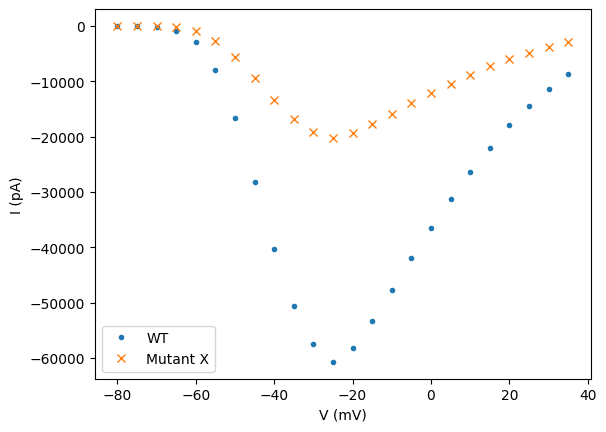

In [4]:
# WT
g_WT = 11.5
g_mutant = 11.5 / 3
cm_WT = cm_mutant = 40

ir = ideal.simulate([g_WT])
ti, ci = protocols.fold(ideal.times(), ir, step_duration, discard=t_hold)
ii_iv, vi_iv = protocols.naiv_iv(ti, ci, dname, is_data=False)

ir = ideal.simulate([g_mutant])
ti, ci = protocols.fold(ideal.times(), ir, step_duration, discard=t_hold)
ii_iv_mutant, vi_iv_m = protocols.naiv_iv(ti, ci, dname, is_data=False)

plt.plot(vi_iv, ii_iv, marker='.', ls='', label='WT')
plt.plot(vi_iv_m, ii_iv_mutant, marker='x', ls='', label='Mutant X')
plt.xlabel('V (mV)')
plt.ylabel('I (pA)')
plt.legend()

In [5]:
def sample(seed, rs=2.5e-3):
    # seed: random seed
    # rs: series resistance
    np.random.seed(seed)

    p_voffset_mean = 0  # mV
    p_rseries_mean = rs  # GOhm
    p_cm_mean = cm_WT  # pF
    #p_cprs_mean = 0  # pF
    #gleak = 0

    std_voffset = 2.5  # mV, see paper 1
    std_rseries = 1.5e-3  # GOhm; LogNormal
    std_cm = 10  # pF; LogNormal
    #std_cprs = 1.0  # pF; LogNormal
    std_est_error = 0.05  # 10% error for rseries estimation?

    voffset = np.random.normal(p_voffset_mean, std_voffset)
    rseries_logmean = np.log(p_rseries_mean) \
            - 0.5 * np.log((std_rseries / p_rseries_mean) ** 2 + 1.)
    rseries_scale = np.sqrt(np.log((std_rseries / p_rseries_mean) ** 2 \
            + 1.))
    rseries = np.random.lognormal(rseries_logmean, rseries_scale)
    #cprs_logmean = np.log(p_cprs_mean) \
    #        - 0.5 * np.log((std_cprs / p_cprs_mean) ** 2 + 1.)
    #cprs_scale = np.sqrt(np.log((std_cprs / p_cprs_mean) ** 2 + 1.))
    #cprs = np.random.lognormal(cprs_logmean, cprs_scale)
    cm_logmean = np.log(p_cm_mean) \
            - 0.5 * np.log((std_cm / p_cm_mean) ** 2 + 1.)
    cm_scale = np.sqrt(np.log((std_cm / p_cm_mean) ** 2 + 1.))
    cm = np.random.lognormal(cm_logmean, cm_scale)
    est_rseries = rseries * (1.0 + np.random.normal(0, std_est_error))
    est_cm = cm * (1.0 + np.random.normal(0, std_est_error))
    #est_cprs = cprs * (1.0 + np.random.normal(0, std_est_error))
    return (voffset, rseries, cm, est_rseries, est_cm)


sem = lambda x: np.std(x, axis=0) / np.sqrt(len(x))

In [6]:
alpha = 0.8  # fraction compensation
mean_rseries = 2.5e-3  # GOhm
n_repeats = 15

# WT simulations
i_iv_WT = []
for i in range(n_repeats):
    voffset, rseries, cm, est_rseries, est_cm = sample(i, mean_rseries)
    model.set_artefact_parameters({
        'cell.Cm': cm,
        'voltage_clamp.R_series': rseries,
        'voltage_clamp.C_prs': 0,
        'voltage_clamp.V_offset_eff': voffset,
        'voltage_clamp.Cm_est': est_cm,
        'voltage_clamp.R_series_est': est_rseries,
        'voltage_clamp.C_prs_est': 0,
        'voltage_clamp.g_leak': 0,
        'voltage_clamp.g_leak_est': 0,
        'voltage_clamp.alpha_R': alpha,
        'voltage_clamp.alpha_P': alpha,
    }, extra=['voltage_clamp.tau_sum', 'voltage_clamp.tau_out'], verbose=False)
    r = model.simulate([g_WT * cm / cm_WT])
    t, c = protocols.fold(model.times(), r, step_duration, discard=t_hold)
    i_iv, v_iv = protocols.naiv_iv(t, c, dname, is_data=False)
    i_iv_WT.append(np.array(i_iv) / est_cm)
mean_i_iv_WT = np.mean(i_iv_WT, axis=0)

# mutant simulations
i_iv_mutant = []
for i in range(n_repeats):
    voffset, rseries, cm, est_rseries, est_cm = sample(i, mean_rseries)
    model.set_artefact_parameters({
        'cell.Cm': cm,
        'voltage_clamp.R_series': rseries,
        'voltage_clamp.C_prs': 0,
        'voltage_clamp.V_offset_eff': voffset,
        'voltage_clamp.Cm_est': est_cm,
        'voltage_clamp.R_series_est': est_rseries,
        'voltage_clamp.C_prs_est': 0,
        'voltage_clamp.g_leak': 0,
        'voltage_clamp.g_leak_est': 0,
        'voltage_clamp.alpha_R': alpha,
        'voltage_clamp.alpha_P': alpha,
    }, extra=['voltage_clamp.tau_sum', 'voltage_clamp.tau_out'], verbose=False)
    r = model.simulate([g_mutant * cm / cm_mutant])
    t, c = protocols.fold(model.times(), r, step_duration, discard=t_hold)
    i_iv, v_iv = protocols.naiv_iv(t, c, dname, is_data=False)
    i_iv_mutant.append(np.array(i_iv) / est_cm)
mean_i_iv_mutant = np.mean(i_iv_mutant, axis=0)

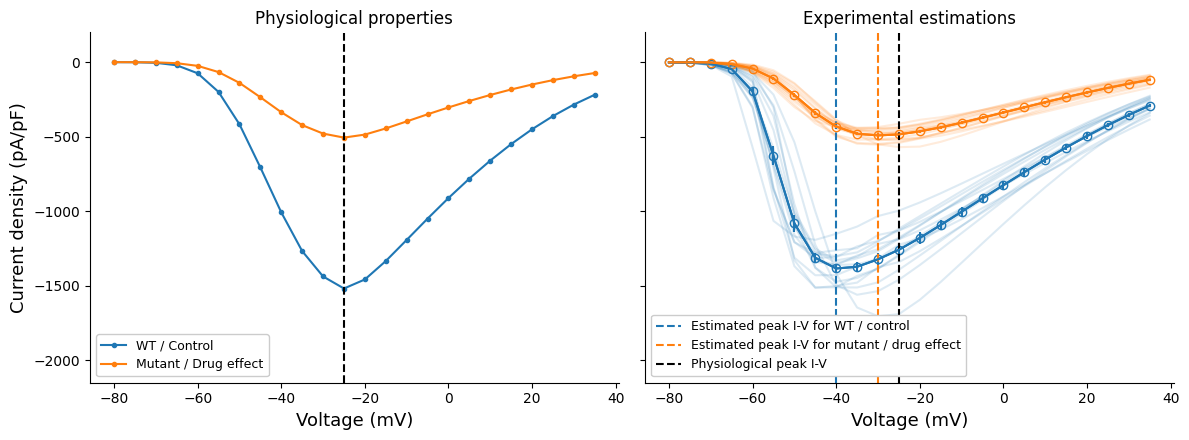

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True, sharey=True)

axes[0].plot(vi_iv, np.array(ii_iv) / cm_WT, marker='.', c='C0', label='WT / Control')
axes[0].plot(vi_iv, np.array(ii_iv_mutant) / cm_mutant, marker='.', c='C1', label='Mutant / Drug effect')
true_v = vi_iv[np.argmin(np.array(ii_iv) / cm_WT)]
axes[0].axvline(true_v, color='k', ls='--')
axes[0].set_xlabel('Voltage (mV)', fontsize=13)
axes[0].set_ylabel('Current density (pA/pF)', fontsize=13)
axes[0].legend(loc=3, framealpha=1, fontsize=9)
axes[0].set_title('Physiological properties')

for i in range(n_repeats):
    axes[1].plot(vi_iv, i_iv_WT[i], 'C0', alpha=0.15)
    axes[1].plot(vi_iv, i_iv_mutant[i], 'C1', alpha=0.15)
axes[1].plot(vi_iv, mean_i_iv_WT, 'C0', marker='o', mfc='none')
axes[1].errorbar(vi_iv, mean_i_iv_WT, yerr=sem(i_iv_WT), c='C0')
axes[1].axvline(vi_iv[np.argmin(mean_i_iv_WT)], color='C0', ls='--', label='Estimated peak I-V for WT / control')

axes[1].plot(vi_iv, mean_i_iv_mutant, 'C1', marker='o', mfc='none')
axes[1].errorbar(vi_iv, mean_i_iv_mutant, yerr=sem(i_iv_mutant), c='C1')
axes[1].axvline(vi_iv[np.argmin(mean_i_iv_mutant)], color='C1', ls='--', label='Estimated peak I-V for mutant / drug effect')

axes[1].axvline(true_v, color='k', ls='--', label='Physiological peak I-V')

axes[1].set_xlabel('Voltage (mV)', fontsize=13)
axes[1].set_title('Experimental estimations')

axes[1].legend(loc=3, framealpha=1, fontsize=9)
axes[1].set_ylim(-2150, 200)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig('mutant-issue.pdf', format='pdf')

In [8]:
print(f'''
Experimental conditions
-----------------------
Cm = LogNormal({cm_WT}, 10) pF (for WT and mutant), estimated with 5% error
R_series = LogNormal({mean_rseries * 1e3}, 1.5) MOhm, estimated with 5% error
V_offset = Normal(0, 2.5) mV
''')


Experimental conditions
-----------------------
Cm = LogNormal(40, 10) pF (for WT and mutant), estimated with 5% error
R_series = LogNormal(2.5, 1.5) MOhm, estimated with 5% error
V_offset = Normal(0, 2.5) mV

